### Company XYZ is an e-commerce site that sells hand-made clothes. You have to build a model that predicts whether a user has a high probability of using the site to perform some illegal activity or not. This is a super common task for data scientists. You only have information about the user first transaction on the site and based on that you have to make your classification ("fraud/no fraud").

### These are the tasks you are asked to do:

#### (1) For each user, determine her country based on the numeric IP address.

#### (2) Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.

#### (3) Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain to her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?

#### (4) Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is, what kind of different user experiences would you build based on the model output?

### Load the package would be used

In [1]:
import pandas as pd
pd.set_option("display.max_columns", 10)
pd.set_option("display.width", 350)
import numpy as np

from datetime import datetime, timedelta

from sklearn.metrics import confusion_matrix, auc, roc_curve, classification_report
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

### Read in the data set

In [2]:
dat0 = pd.read_csv("../Datasets/Fraud/Fraud_data.csv")
dat0.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,...,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,...,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,...,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,...,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,...,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,...,Safari,M,45,4.155831e+08,0


In [3]:
ip_addresses = pd.read_csv("../Datasets/Fraud/IpAddress_to_Country.csv")
ip_addresses.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


#### (1) For each user, determine her country based on the numeric IP address.

In [4]:
dat0_country = [None] * dat0.shape[0]
  
for i in range(dat0.shape[0]):
    tmp = ip_addresses[(dat0["ip_address"][i] >= ip_addresses["lower_bound_ip_address"]) & 
                       (dat0["ip_address"][i] <= ip_addresses["upper_bound_ip_address"])]
    if (len(tmp) == 1):
        dat0_country[i] = tmp["country"].values
        
dat0["country"] = dat0_country
dat0.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,...,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,...,M,39,7.327584e+08,0,[Japan]
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,...,F,53,3.503114e+08,0,[United States]
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,...,M,53,2.621474e+09,1,[United States]
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,...,M,41,3.840542e+09,0,None
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,...,M,45,4.155831e+08,0,[United States]


In [5]:
dat0["country"] = dat0["country"].str.get(0)
print(dat0.groupby("country").size().nlargest(10))

country
United States        58049
China                12038
Japan                 7306
United Kingdom        4490
Korea Republic of     4162
Germany               3646
France                3161
Canada                2975
Brazil                2961
Italy                 1944
dtype: int64


#### (2) Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.

In [6]:
#### Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "13.0.1" 2019-10-15; Java(TM) SE Runtime Environment (build 13.0.1+9); Java HotSpot(TM) 64-Bit Server VM (build 13.0.1+9, mixed mode, sharing)
  Starting server from /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/d3/zs9fr3kx3x18h3l0hq4mc8x00000gn/T/tmpwayitaai
  JVM stdout: /var/folders/d3/zs9fr3kx3x18h3l0hq4mc8x00000gn/T/tmpwayitaai/h2o_jinliu_started_from_python.out
  JVM stderr: /var/folders/d3/zs9fr3kx3x18h3l0hq4mc8x00000gn/T/tmpwayitaai/h2o_jinliu_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.1
H2O cluster version age:,17 days
H2O cluster name:,H2O_from_python_jinliu_73cehg
H2O cluster total nodes:,1
H2O cluster free memory:,4 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


### Before constructing classification models, we need to specify features to this model which could be

#### Time difference between sign-up time and purchase time;
#### Whether the device ID is unique or certain users are sharing the same device (though it is possible that family members/close friends may share the same device, it is still an indicator of fake account)
#### Same for IP address. Many different users having the same IP address could be an indicator of faked accounts
#### Time variables such as the week of the year and the day of the week

In [7]:
#### Time difference between sign-up time and purchase time
dat0["purchase_time"] = pd.to_datetime(dat0["purchase_time"])
dat0["signup_time"] = pd.to_datetime(dat0["signup_time"])
dat0["purchase_signup_diff"] = (dat0["purchase_time"] - dat0["signup_time"]).dt.total_seconds()

#### Whether the device ID is unique or certain users are sharing the same device
dat0["device_id_count"] = dat0.groupby("device_id")["device_id"].transform("count")

#### Same for IP address
dat0["ip_address_count"] = dat0.groupby("ip_address")["ip_address"].transform("count")

#### data set for the model. Drop first 3 vairables and device id
dat0_rf = dat0.drop(["user_id", "signup_time", "purchase_time", "device_id"], axis = 1)
dat0_rf["country"].replace([None], "Not_found", inplace = True)

#### Keep the top 50 countries, everything else is "other" get countries from 51 to last one 
other_countries = dat0_rf.groupby("country").size().sort_values(ascending = False)[50:].index
x = dict.fromkeys(other_countries, "Other")
dat0_rf["country"] = dat0_rf["country"].replace(x)

In [8]:
dat0_rf.head()

,purchase_value,source,browser,sex,age,...,class,country,purchase_signup_diff,device_id_count,ip_address_count
0,34,SEO,Chrome,M,39,...,0,Japan,4506682.0,1,1
1,16,Ads,Chrome,F,53,...,0,United States,17944.0,1,1
2,15,SEO,Opera,M,53,...,1,United States,1.0,12,12
3,44,SEO,Safari,M,41,...,0,Not_found,492085.0,1,1
4,39,Ads,Safari,M,45,...,0,United States,4361461.0,1,1


In [9]:
dat_h2o = H2OFrame(dat0_rf)
dat_h2o["class"] = dat_h2o["class"].asfactor()
dat_h2o["source"] = dat_h2o["source"].asfactor()
dat_h2o["browser"] = dat_h2o["browser"].asfactor()
dat_h2o["sex"] = dat_h2o["sex"].asfactor()
dat_h2o["country"] = dat_h2o["country"].asfactor()
dat_h2o.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,purchase_value,source,browser,sex,age,ip_address,class,country,purchase_signup_diff,device_id_count,ip_address_count
type,int,enum,enum,enum,int,real,enum,enum,real,int,int
mins,9.0,,,,18.0,52093.4968949854,,,1.0,1.0,1.0
mean,36.93537243898573,,,,33.14070358409658,2152145330.95884,,,4932029.248623586,1.684366562549633,1.6027185134205115
maxs,154.0,,,,76.0,4294850499.67884,,,10367972.0,20.0,20.0
sigma,18.322762148662083,,,,8.617733490961466,1248497030.1004243,,,3126263.1184443026,2.6169536028041733,2.5962395273758414
zeros,0,,,,0,0,,,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,0
0,34.0,SEO,Chrome,M,39.0,732758368.79972,0,Japan,4506682.0,1.0,1.0
1,16.0,Ads,Chrome,F,53.0,350311387.865908,0,United States,17944.0,1.0,1.0
2,15.0,SEO,Opera,M,53.0,2621473820.11095,1,United States,1.0,12.0,12.0


##### Build a random forest model

In [10]:
index = dat_h2o["class"].stratified_split(test_frac = 0.34, seed = 2020)
train_dat = dat_h2o[index == "train"]
test_dat = dat_h2o[index == "test"]
X = ["purchase_value", "source", "browser", "sex", "age", "ip_address", "country", "purchase_signup_diff", "device_id_count", "ip_address_count"]
Y = "class"

RF0 = H2ORandomForestEstimator(balance_classes = False, ntrees = 100, max_depth = 20, 
                               mtries = -1, seed = 2019, score_each_iteration = True)
RF0.train(x = X, y = Y, training_frame = train_dat)

drf Model Build progress: |███████████████████████████████████████████████| 100%


##### Examine if overfitting (though it's unlikely for a random forest)

In [11]:
train_true = train_dat.as_data_frame()["class"].values
test_true = test_dat.as_data_frame()["class"].values
train_pred = RF0.predict(train_dat).as_data_frame()["predict"].values
test_pred = RF0.predict(test_dat).as_data_frame()["predict"].values

train_confusion = confusion_matrix(train_true, train_pred)
print (train_confusion/train_confusion.astype(np.float).sum(axis = 1))

test_confusion = confusion_matrix(test_true, test_pred)
print (test_confusion/test_confusion.astype(np.float).sum(axis = 1))

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
[[1.         0.        ]
 [0.03861982 0.62623126]]
[[0.99987115 0.00124714]
 [0.04831748 0.53232176]]


In [12]:
train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)
print(classification_report(y_true=test_true, y_pred = (test_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     46567
           1       1.00      0.53      0.69      4811

    accuracy                           0.96     51378
   macro avg       0.98      0.77      0.84     51378
weighted avg       0.96      0.96      0.95     51378



##### Variable importance

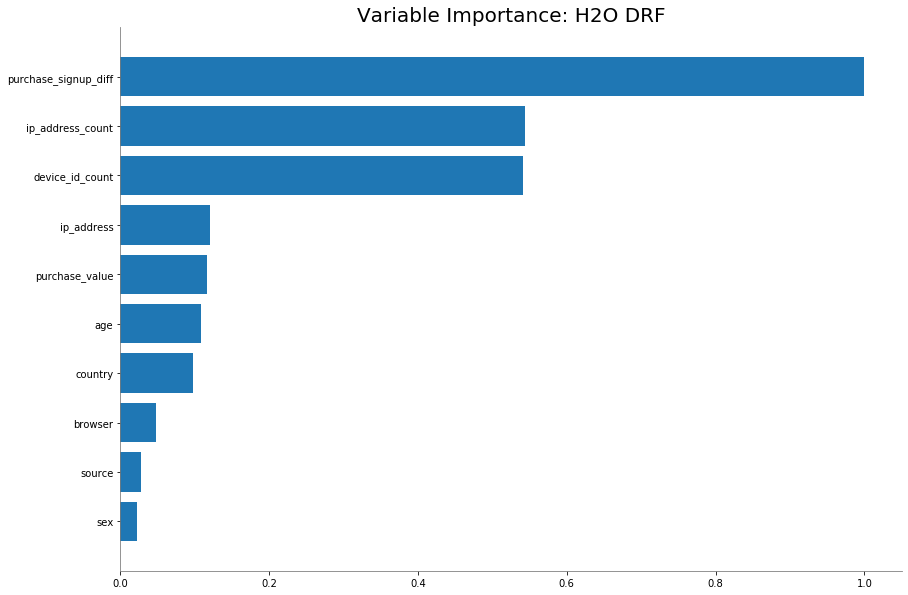

In [13]:
RF0.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%

PartialDependence: Partial Dependence Plot of model DRF_model_python_1578095372346_1 on column 'purchase_signup_diff'


,purchase_signup_diff,mean_response,stddev_response,std_error_mean_response
0,1.000000e+00,0.297642,0.178999,0.000567
1,5.456837e+05,0.056053,0.083476,0.000264
2,1.091366e+06,0.049186,0.077356,0.000245
3,1.637049e+06,0.048683,0.075731,0.000240
4,2.182732e+06,0.048881,0.074056,0.000234
5,2.728414e+06,0.051054,0.077936,0.000247
6,3.274097e+06,0.049375,0.073761,0.000234
7,3.819780e+06,0.048150,0.073877,0.000234
8,4.365462e+06,0.046654,0.074117,0.000235
9,4.911145e+06,0.046857,0.074054,0.000234



PartialDependence: Partial Dependence Plot of model DRF_model_python_1578095372346_1 on column 'device_id_count'


,device_id_count,mean_response,stddev_response,std_error_mean_response
0,1.0,0.068583,0.169412,0.000536
1,2.0,0.268727,0.173185,0.000548
2,3.0,0.284744,0.182218,0.000577
3,4.0,0.267369,0.180500,0.000572
4,5.0,0.216334,0.192488,0.000610
5,6.0,0.199871,0.196487,0.000622
6,7.0,0.198944,0.196249,0.000621
7,8.0,0.198670,0.196311,0.000622
8,9.0,0.206078,0.194987,0.000617
9,10.0,0.213136,0.194424,0.000616



PartialDependence: Partial Dependence Plot of model DRF_model_python_1578095372346_1 on column 'ip_address_count'


,ip_address_count,mean_response,stddev_response,std_error_mean_response
0,1.0,0.073145,0.147833,0.000468
1,2.0,0.163328,0.167855,0.000532
2,3.0,0.189108,0.192696,0.000610
3,4.0,0.191001,0.194260,0.000615
4,5.0,0.178086,0.198151,0.000627
5,6.0,0.178010,0.200038,0.000633
6,7.0,0.179697,0.200009,0.000633
7,8.0,0.178763,0.200117,0.000634
8,9.0,0.174505,0.200952,0.000636
9,10.0,0.173324,0.200990,0.000636


[, , ]

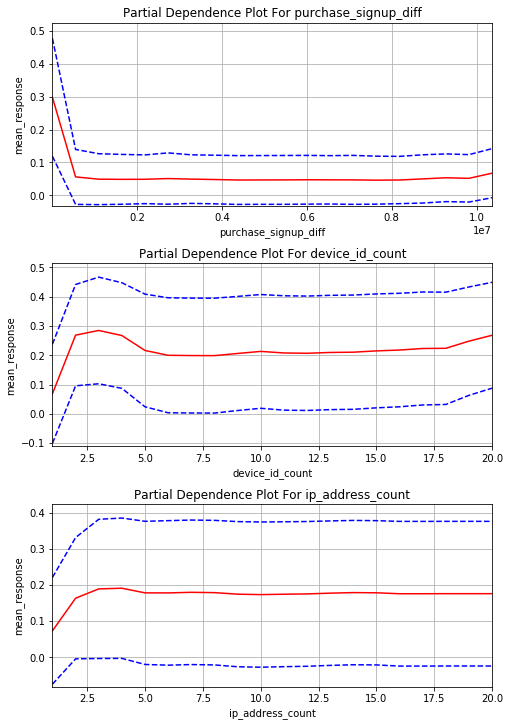

In [14]:
RF0.partial_plot(data = train_dat, cols = ["purchase_signup_diff", "device_id_count", "ip_address_count"], plot = True)